In [1]:
from google.colab import drive
drive.mount('/content/drive')
running_number = 10

Mounted at /content/drive


(20000, 7, 3)
(20000, 1025)
(20000, 1025)


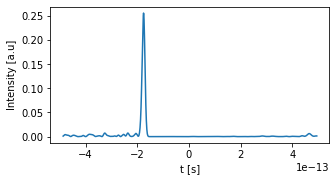

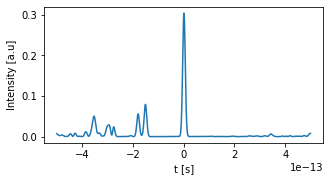

[[['1' '2.042e-06' 'silicono2']
  ['3.4777237564709433' '9.347e-06' 'silicon']
  ['1.4440236216729967' '4.7930000000000005e-06' 'silicono2']
  ['3.4777237564709433' '6.307000000000001e-06' 'silicon']
  ['1.4440236216729967' '5.8410000000000005e-06' 'silicono2']]

 [['1' '3.661e-06' 'silicono2']
  ['3.4777237564709433' '8.903000000000001e-06' 'silicon']
  ['1.4440236216729967' '5.696e-06' 'silicono2']
  ['3.4777237564709433' '3.7640000000000003e-06' 'silicon']
  ['1.4440236216729967' '9.160000000000001e-07' 'silicono2']]

 [['0' '4.3800000000000003e-07' 'silicon']
  ['1.4440236216729967' '2.6090000000000003e-06' 'silicono2']
  ['3.4777237564709433' '8.165e-06' 'silicon']
  ['1.4440236216729967' '3.0020000000000002e-06' 'silicono2']
  ['3.4777237564709433' '4.359e-06' 'silicon']]

 ...

 [['0' '8.852000000000001e-06' 'silicon']
  ['1.4440236216729967' '7.958e-06' 'silicono2']
  ['3.4777237564709433' '5.513e-06' 'silicon']
  ['1.4440236216729967' '8.637e-06' 'silicono2']
  ['3.47772375647

In [13]:
from ctypes import Structure
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import cmath
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams["figure.figsize"] = [5, 2.5]

second = 1
fs = second * 1e-15
ps = second * 1e-12
meter = 1
nm = meter * 1e-9
um = meter * 1e-6
mm = meter * 1e-3


pad = 500  # 500
N_samples = 2 ** 10  # 10000
c_const = 3e8 * meter / second
n_ref = 1

dt = (2 * pad * fs) / N_samples
t_vec = np.arange(-pad * fs, pad * fs + dt, dt)
f_vec = np.fft.fftshift(np.fft.fftfreq(t_vec.shape[0], d=dt))
omega_vec = (2 * np.pi * f_vec)
f_s = f_vec[40]-f_vec[39]

with open("/content/drive/MyDrive/Thin_layers_data/data_5layers_20000.npy", 'rb') as f:
    vec_structure = np.load(f)
    vec_T = np.load(f)
    vec_R = np.load(f)

print(vec_structure.shape)
print(vec_T.shape)
print(vec_R.shape)

def non_zero(x_vec, y_vec, min_num=0.001):
  i = 0
  j = len(x_vec) - 1
  while y_vec[i] < min_num:
    i = i + 1
  while y_vec[j] < min_num:
    j = j - 1
    # k = min(i , len(x_vec) - j)
  return x_vec[i:j], y_vec[i:j]

# def generate_pulse(index):
#     plt.figure()
#     x_in_time, y_in_time = non_zero(t_vec, vec_T[index])
#     plt.plot(x_in_time, y_in_time)
#     x_in_time, y_in_time = non_zero(t_vec, vec_R[index])
#     plt.plot(x_in_time, y_in_time)
#     plt.legend(['T', 'R'], loc='upper left')
#     plt.show()

def generate_pulse(index):
    plt.figure()
    x_in_time, y_in_time = non_zero(t_vec, vec_T[index])
    plt.plot(x_in_time, y_in_time)
    x_in_time, y_in_time = non_zero(t_vec, vec_R[index])
    plt.xlabel("t [s]")
    plt.ylabel("Intensity [a.u]")
    plt.figure()
    plt.plot(x_in_time, y_in_time)
    plt.xlabel("t [s]")
    plt.ylabel("Intensity [a.u]")
    #plt.legend(['T', 'R'], loc='upper left')
    plt.show()

def encode_refractive(vec_structure):
  for structure in vec_structure:
    if structure[0,2] == 'silicon':
      structure[0,0] = 0
    else:
      structure[0,0] = 1
  return np.array(vec_structure)


generate_pulse(index= random.randint(0,9))
vec_structure = vec_structure[:,1:-1,:] #without air
vec_structure = encode_refractive(vec_structure)
print(vec_structure)
vec_structure[:,:,1] = np.float32(vec_structure[:,:,1]) * (10**7)

(18000, 1025, 2)
float32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1025)]       0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1025)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          525312      ['input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 512)          525312      ['input_1[0][0]']                
                                                                     

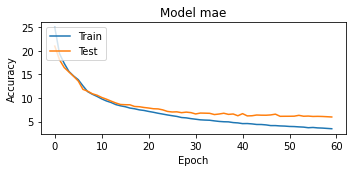

' Tasks\n\n1. How to clear the memory after each run? (check to see that the input layers are not increasing)\n2a. Encode the Refractive index into 1-Hot encoding\n2b. Remove the air Width from the width vector\n3. Change the model so that every head has a new size (2 and 2)\n4. Train with different losses for each head (Width-mae, RefIdx- ??)\n5. Add more data and see if it still converges\n.\n.\n.\n100. Add graphics that compare structures and waveforms\n\n\n\n'

In [ ]:
import tensorflow as tf
import keras
import os
import time
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

tf.keras.backend.clear_session()

batch_size = 128
epochs = 60
random_state = 9990
test_size = 0.1

x_samples = np.dstack((vec_T, vec_R))
y_samples = vec_structure[:,:,:2].astype(np.float32)

x_train, x_test, y_train, y_test = train_test_split(x_samples, y_samples, 
                                                    test_size=test_size,
                                                    random_state = random_state)

x_test, x_dev, y_test, y_dev = train_test_split(x_test, y_test, 
                                                    test_size=0.5,
                                                random_state=0)

print(x_train.shape)
print(y_train.dtype)

# Model
T_vec_input = Input(shape=x_train.shape[1])
R_vec_input = Input(shape=x_train.shape[1])
R_vec_first_layer = Dense(512, activation='relu')(R_vec_input)
T_vec_first_layer = Dense(512, activation='relu')(T_vec_input)
concat_first = tf.keras.layers.Concatenate()([R_vec_first_layer,
                                              T_vec_first_layer])
x = Dense(512, activation='relu')(concat_first)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
Width_output = Dense(y_train.shape[1], activation='relu')(x)
Refidx_output = Dense(2, activation='softmax')(x)

model = Model(inputs=[T_vec_input, R_vec_input],
              outputs=[Width_output, Refidx_output])

model.summary()
plot_model(model, 
           to_file='/content/drive/MyDrive/Thin_layers_data/model_plot.png',
           show_shapes=True, show_layer_names=False)


# model compilation
model.compile(loss=['mae', 'sparse_categorical_crossentropy'], 
              loss_weights=[1.0, 1.0],
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mae'])

# save model
model_file = '/content/drive/MyDrive/Thin_layers_data/model.h5'
checkpoint = ModelCheckpoint(model_file, verbose=1, monitor='val_loss', 
                             save_best_only=True, mode='auto')

# model fit
history = model.fit([x_train[:,:,0], x_train[:,:,1]], [y_train[:,:,1], y_train[:,0,0]],
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([x_dev[:,:,0], 
                            x_dev[:,:,1]], [y_dev[:,:,1], y_dev[:,0,0]]),
          callbacks=[checkpoint])

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model mae')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# plt.savefig('/content/drive/MyDrive/Thin_layers_data/accuracy_basic.png')
plt.show()

# print(y_test[:,:,1], y_test[:,0,0])
# print()
# y_pred = model.predict([x_test[:,:,0], x_test[:,:,1]])
# print((y_pred[0]).shape)
# print((y_pred[1]).shape)
# print(y_pred[0], y_pred[1])

''' Tasks

1. How to clear the memory after each run? (check to see that the input layers are not increasing)
2a. Encode the Refractive index into 1-Hot encoding
2b. Remove the air Width from the width vector
3. Change the model so that every head has a new size (2 and 2)
4. Train with different losses for each head (Width-mae, RefIdx- ??)
5. Add more data and see if it still converges
.
.
.
100. Add graphics that compare structures and waveforms



'''


In [ ]:
loss_history = np.array(history.history['loss'])
val_loss_history = np.array(history.history['val_loss'])

outfile = "/content/drive/MyDrive/Thin_layers_data/new_data/layers5_DNN_" + str(running_number) + "_history"
np.savez(outfile, loss_history = loss_history, val_loss_history = val_loss_history)

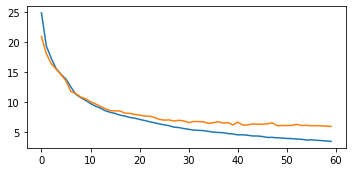

In [ ]:
outfile = '/content/drive/MyDrive/Thin_layers_data/new_data/layers5_DNN_' + str(running_number) + '_history.npz'
npzfile = np.load(outfile)
d = dict(npzfile)
plt.figure()
plt.plot(d['loss_history'])
plt.plot(d['val_loss_history'])
plt.show()

32/32 [==============================] - 0s 2ms/step


<ipython-input-92-6a079bfca6b0>:10: RuntimeWarning: divide by zero encountered in true_divide
  lambda_vec = (2 * np.pi * c_const / omega_vec)



i = 0, index = 63
n original:
1.0
d original:
[8.1950002e-06 9.5369996e-06 4.6500003e-07 8.1370008e-06 5.4030002e-06]
n prediction:
1.0
d prediction:
[8.5181264e-06 9.5298201e-06 9.3952207e-07 8.3001232e-06 4.3144901e-06]


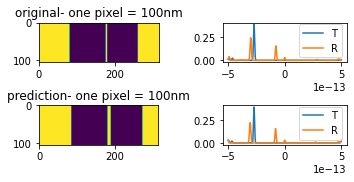

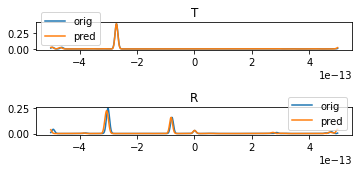

correlation t = 99% 
correlation r = 84% 
correlation structure = 84%
32/32 [==============================] - 0s 2ms/step

i = 1, index = 28
n original:
1.0
d original:
[8.597e-06 2.660e-06 9.960e-06 7.960e-06 1.102e-06]
n prediction:
1.0
d prediction:
[8.4172534e-06 2.6483569e-06 8.7613626e-06 8.2495244e-06 1.2017588e-06]


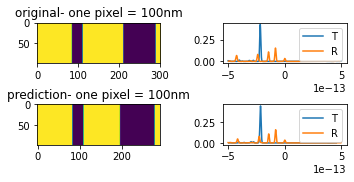

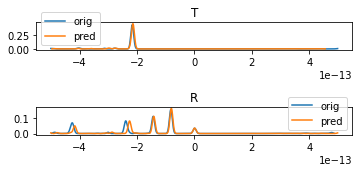

correlation t = 94% 
correlation r = 81% 
correlation structure = 94%
32/32 [==============================] - 0s 2ms/step

i = 2, index = 12
n original:
0.0
d original:
[1.273e-06 8.376e-06 2.824e-06 9.923e-06 5.257e-06]
n prediction:
0.0
d prediction:
[1.3673429e-06 9.0959638e-06 2.4672281e-06 7.4495965e-06 6.5978265e-06]


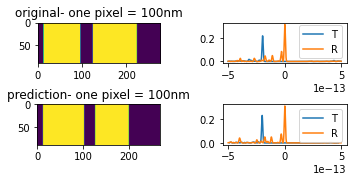

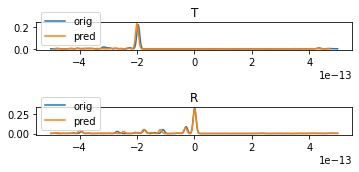

correlation t = 84% 
correlation r = 96% 
correlation structure = 85%


In [ ]:
# Add graphics that compare structures and waveforms

# START- the relevat parts form the pycharm project

c_const = 3e8 * meter / second
n_ref = 1

f_vec = np.fft.fftshift(np.fft.fftfreq(t_vec.shape[0], d=dt))
omega_vec = (2 * np.pi * f_vec)
lambda_vec = (2 * np.pi * c_const / omega_vec)

def P_matrix(n, d, wave_length):
    phase = 2 * (math.pi / wave_length) * d * n
    P11 = cmath.exp(-1j * phase)
    P22 = cmath.exp(1j * phase)
    P = np.array([[P11, 0], [0, P22]])
    return P

def T_matrix(n1, n2):
    n1 = n1.real
    n2 = n2.real
    T11 = (n1 + n2) / (2 * n1)
    T12 = (n1 - n2) / (2 * n1)
    T21 = (n1 - n2) / (2 * n1)
    T22 = (n1 + n2) / (2 * n1)
    T = np.array([[T11, T12], [T21, T22]])
    return T

def P_list(NDlist, wave_length):
    lis = []
    for i in range(len(NDlist) - 2):
        n = NDlist[i + 1][0]
        d = NDlist[i + 1][1]
        lis.append(P_matrix(n, d, wave_length))
    return lis

def T_list(NDlist):
    lis = []
    for i in range(len(NDlist) - 1):
        lis.append(T_matrix(NDlist[i][0], NDlist[i + 1][0]))
    return lis

def M_matrix(NDlist, wave_length):
    Tlist = T_list(NDlist)
    Plist = P_list(NDlist, wave_length)
    M = np.array([[1, 0], [0, 1]])
    for i in range(len(Plist)):
        m = np.dot(Tlist[i], Plist[i])
        M = np.dot(M, m)
    M = np.dot(M, Tlist[-1])
    return M

def reflectance(NDlist, wave_length):
    M = M_matrix(NDlist, wave_length)
    r = M[1][0] / M[0][0]
    return r

def transmittance(NDlist, wave_length):
    M = M_matrix(NDlist, wave_length)
    t = 1 / M[0][0]
    return t

def t_spectrum_vec(NDlist, vec):
    lis = []
    for i in range(vec.shape[0]):
        t = transmittance(NDlist, vec[i])
        lis.append(t)
    return lis


def r_spectrum_vec(NDlist, vec):
    lis = []
    for i in range(vec.shape[0]):
        r = reflectance(NDlist, vec[i])
        lis.append(r)
    return lis

def generate_vector(NDlist):
    width_time = 12 * fs
    carrier_wavelength = 800 * nm
    omega_0 = np.divide((2 * np.pi * c_const), (n_ref * carrier_wavelength))
    input_wave_amp = np.exp(- 2 * np.log(2) * np.square(t_vec / (width_time)))
    input_wave_phase = 0
    input_wave_phase = input_wave_phase + omega_0 * t_vec
    input_wave = input_wave_amp * np.exp(1j * input_wave_phase)
    input_wave_spectrum = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(input_wave)))
    reflected_lambda = r_spectrum_vec(NDlist, lambda_vec) * input_wave_spectrum
    transmitted_lambda = t_spectrum_vec(NDlist, lambda_vec) * input_wave_spectrum
    output_wave_reflected = np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(reflected_lambda)))
    output_wave_transmitted = np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(transmitted_lambda)))
    return (np.abs(output_wave_transmitted) ** 2), (np.abs(output_wave_reflected) ** 2)

# END- the relevat parts form the pycharm project

def create_NDlist(n , d):
  NDlist = np.zeros((len(d),2))
  for i in range(len(d)):
    if i % 2 == n:
      NDlist[i,0] = 3.4777237564709433
    else:
      NDlist[i,0] = 1.4440236216729967
  NDlist[:,1] = d
  return NDlist

def plot_structure(NDlist):
  # d1 = int(NDlist[0][1] * (10**7))
  # d2 = int(NDlist[1][1] * (10**7))
  d = NDlist[:,1] * (10**7)

  d_sum = int(np.sum(d))
  image = np.zeros((int(d_sum/3) , d_sum))
  n = int(NDlist[0][0] < NDlist[1][0])
  point = 0
  for i in range(len(d)-1):
    image[:,point:point+ int(d[i])] = 255 * ((i-n)%2)
    point = point + int(d[i])
  image[: ,point:] = 255 * ((i-n+1)%2)
  return image

def add_air(NDlist):
  new = np.zeros((NDlist.shape[0] + 2,2))
  new[0,0] = 1
  new[NDlist.shape[0] + 1,0] = 1
  new[0,1] = 0
  new[NDlist.shape[0] + 1,1] = 0
  new[1:-1, :] = NDlist
  return new

def calculate_correlation_structure(NDlist_original, NDlist_prediction):
  if (NDlist_original[0,0] > 3 and NDlist_prediction[0,0] < 3) or (NDlist_original[0,0] < 3 and NDlist_prediction[0,0] > 3):
    return 0
  num_of_layers = NDlist_original.shape[0]
  corr = 0 
  for i in range(num_of_layers):
      corr += min(d_original[i], d_prediction[i])/max(d_original[i], d_prediction[i])
  corr /= num_of_layers
  corr *= 100
  corr = int(corr)/100
  return corr

def correl(x,y):
  up = abs(x-y)
  down = x+y
  correl = 1 - np.average(up/down)
  return correl


########################################
# THE MAIN PART OF THE CODE STARTS HERE!
########################################

# n_prediction = 0 or 1
# d_prediction = [d1 , d2, d3, ... , d20]

mm = 10**(-6)

for i in range(3):
  index = random.randint(0,100)
  n_original = y_test[index][0,0]
  d_original = y_test[index,:,1] * (10**-7)

  y_pred = model.predict([x_test[:,:,0], x_test[:,:,1]])
  n_prediction_vector = np.float32(y_pred[1] < 0.5)[:,0]
  d_prediction_vector = y_pred[0]* (10**-7)

  n_prediction = n_prediction_vector[index]
  d_prediction = d_prediction_vector[index]
  print("\ni = {}, index = {}".format(i, index))
  print("n original:")
  print(n_original)
  print("d original:")
  print(d_original)
  print("n prediction:")
  print(n_prediction)
  print("d prediction:")
  print(d_prediction)

  NDlist_original = create_NDlist(n_original, d_original)
  NDlist_prediction = create_NDlist(n_prediction, d_prediction)

  plt.figure(i)
  image_original = plot_structure(NDlist_original)
  image_prediction = plot_structure(NDlist_prediction)
  plt.subplot(2,2,1)
  plt.imshow(image_original)
  plt.title('original- one pixel = 100nm')
  plt.subplot(2,2,3)
  plt.imshow(image_prediction)
  plt.title('prediction- one pixel = 100nm')
  plt.subplot(2,2,2)
  x_t_original, y_t_original = non_zero(t_vec, x_test[index, :,0])
  x_r_original, y_r_original = non_zero(t_vec, x_test[index, :,1])
  plt.plot(x_t_original, y_t_original)
  plt.plot(x_r_original, y_r_original)
  plt.legend(['T' , 'R'])
  plt.subplot(2,2,4)
  y_t_prediction0, y_r_prediction0 = generate_vector(add_air(NDlist_prediction))
  x_t_prediction, y_t_prediction = non_zero(t_vec, y_t_prediction0)
  x_r_prediction, y_r_prediction = non_zero(t_vec, y_r_prediction0)
  plt.plot(x_t_prediction, y_t_prediction)
  plt.plot(x_r_prediction, y_r_prediction)
  plt.legend(['T' , 'R'])
  plt.figure()
  plt.subplot(2,1,1)
  plt.plot(x_t_original, y_t_original)
  plt.plot(x_t_prediction, y_t_prediction)
  plt.legend(['orig' , 'pred'])
  plt.title('T')
  plt.subplot(2,1,2)
  plt.plot(x_r_original, y_r_original)
  plt.plot(x_r_prediction, y_r_prediction)
  plt.legend(['orig' , 'pred'])
  plt.title('R')

  plt.show()

  correlation_t = int(100 * np.abs(np.corrcoef(x_test[index, :,0], y_t_prediction0)[0,1]))
  correlation_r = int(100 * np.abs(np.corrcoef(x_test[index, :,1], y_r_prediction0)[0,1]))
  correlation_structure = int(calculate_correlation_structure(NDlist_original, NDlist_prediction) * 100)
  print("correlation t = {}% \ncorrelation r = {}% \ncorrelation structure = {}%".format(correlation_t, correlation_r, correlation_structure))

32/32 [==============================] - 0s 2ms/step


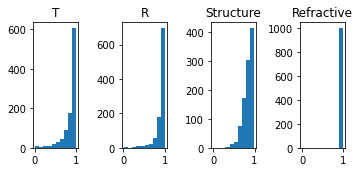

average T: 86.38
average R: 89.68
average Structure: 84.09
average Refractive: 99.9


In [ ]:
# Histogram of Correlation for the test set

y_pred = model.predict([x_test[:,:,0], x_test[:,:,1]])
n_prediction_vector = np.float32(y_pred[1] < 0.5)[:,0]
d_prediction_vector = y_pred[0] * (10**-7)

def prediction(index, n_prediction_vector, d_prediction_vector):
  n_prediction = n_prediction_vector[index]
  d_prediction = d_prediction_vector[index]
  return n_prediction, d_prediction

def ND_to_TR(n_prediction, d_prediction):
  NDlist_prediction = create_NDlist(n_prediction, d_prediction)
  t_prediction, r_prediction = generate_vector(add_air(NDlist_prediction))
  return t_prediction, r_prediction

correlation_structure = []
vec_t_original = x_test[:,:,0]
vec_r_original = x_test[:,:,1]
vec_t_prediction = []
vec_r_prediction = []
refractive_correlation = []
for i in range(len(x_test)):
  n_prediction, d_prediction = prediction(i, n_prediction_vector, d_prediction_vector)
  t_prediction, r_prediction = ND_to_TR(n_prediction, d_prediction)
  vec_t_prediction.append(t_prediction)
  vec_r_prediction.append(r_prediction)
  n_original = y_test[i,0,0]
  d_original = y_test[i,:,1]
  d_original = d_original * (10**-7)
  if n_original == n_prediction:
    refractive_correlation.append(1)
  else:
    refractive_correlation.append(0)
  NDlist_original = create_NDlist(n_original, d_original)
  NDlist_prediction = create_NDlist(n_prediction, d_prediction)
  correlation_structure.append(calculate_correlation_structure(NDlist_original, NDlist_prediction))

vec_t_prediction = np.array(vec_t_prediction)
vec_r_prediction = np.array(vec_r_prediction)

# Calculate correlation
correlation_vec_t = []
correlation_vec_r = []
for i in range(len(x_test)):
  correlation_vec_t.append(np.abs(np.corrcoef(vec_t_original[i], vec_t_prediction[i])[0,1]))
  correlation_vec_r.append(np.abs(np.corrcoef(vec_r_original[i], vec_r_prediction[i])[0,1]))

correlation_structure = np.array(correlation_structure)
correlation_vec_t = np.array(correlation_vec_t)
correlation_vec_r = np.array(correlation_vec_r)
  
plt.figure()
plt.subplot(1,4,1)
plt.title('T')
plt.hist(correlation_vec_t)
plt.subplot(1,4,2)
plt.title('R')
plt.hist(correlation_vec_r)
plt.subplot(1,4,3)
plt.title('Structure')
plt.hist(correlation_structure)
plt.subplot(1,4,4)
plt.title('Refractive')
plt.hist(refractive_correlation)
plt.show()

print('average T: ' + str(int(np.average(correlation_vec_t) * 10000)/100))
print('average R: ' + str(int(np.average(correlation_vec_r) * 10000)/100))
print('average Structure: ' + str(int(np.average(correlation_structure) * 10000)/100))
print('average Refractive: ' + str(int(np.average(refractive_correlation) * 10000)/100))

In [ ]:
outfile = '/content/drive/MyDrive/Thin_layers_data/new_data/layers5_DNN_' + str(running_number) + '_NDlist'
np.savez(outfile, n = n_prediction_vector, d = d_prediction_vector)

In [ ]:
outfile = '/content/drive/MyDrive/Thin_layers_data/new_data/layers5_DNN_' + str(running_number) + '_NDlist.npz'
npzfile = np.load(outfile)
d = dict(npzfile)
print(d.keys())
print(d['n'].shape)
print(d['d'].shape)

dict_keys(['n', 'd'])
(1000,)
(1000, 5)


In [ ]:
outfile = '/content/drive/MyDrive/Thin_layers_data/new_data/layers5_DNN_' + str(running_number) + '_examples'
savez_dict = {}
for i in range(1000):
  savez_dict['unknown_layers_DNN_t_original_example' + str(i)] = vec_t_original[i]
  savez_dict['unknown_layers_DNN_t_prediction_example' + str(i)] = vec_t_prediction[i]
  savez_dict['unknown_layers_DNN_r_original_example' + str(i)] = vec_r_original[i]
  savez_dict['unknown_layers_DNN_r_prediction_example' + str(i)] = vec_r_prediction[i]
np.savez(outfile, t_vec = t_vec, **savez_dict)

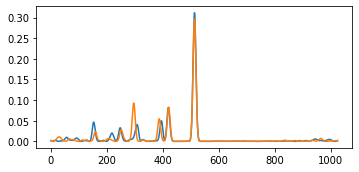

In [ ]:
outfile = '/content/drive/MyDrive/Thin_layers_data/new_data/layers5_DNN_' + str(running_number) + '_examples.npz'
npzfile = np.load(outfile)
d = dict(npzfile)
plt.figure()
plt.plot(d['unknown_layers_DNN_r_original_example20'])
plt.plot(d['unknown_layers_DNN_r_prediction_example20'])
plt.show()

In [ ]:
outfile = '/content/drive/MyDrive/Thin_layers_data/new_data/layers5_DNN_' + str(running_number) + '_histogram'
np.savez(outfile, T_histogram = correlation_vec_t,
         R_histogram = correlation_vec_r,
         Structure_histogram = correlation_structure,
         Refractive_histogram = refractive_correlation)

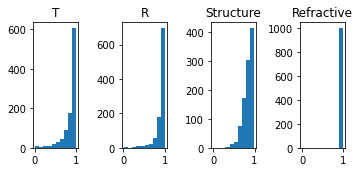

In [ ]:
outfile = '/content/drive/MyDrive/Thin_layers_data/new_data/layers5_DNN_' + str(running_number) + '_histogram.npz'
npzfile = np.load(outfile)
d = dict(npzfile)

plt.figure()
plt.subplot(1,4,1)
plt.title('T')
plt.hist(d['T_histogram'])
plt.subplot(1,4,2)
plt.title('R')
plt.hist(d['R_histogram'])
plt.subplot(1,4,3)
plt.title('Structure')
plt.hist(d['Structure_histogram'])
plt.subplot(1,4,4)
plt.title('Refractive')
plt.hist(d['Refractive_histogram'])
plt.show()

In [ ]:
def subtraction(image_original, image_prediction):
  d = max(image_original.shape[1], image_prediction.shape[1])
  h = min(image_original.shape[0], image_prediction.shape[0])
  sub1 = np.zeros((h,d))
  sub1[:,:image_original.shape[1]] = image_original[:h,:]
  sub2 = np.zeros((h,d))
  sub2[:,:image_prediction.shape[1]] = image_prediction[:h,:]
  sub = np.abs(sub1-sub2)
  sub = (sub > 1) * 255
  sub[:,min(image_original.shape[1], image_prediction.shape[1]):] = 255
  return sub

In [ ]:
#generate filter images
outfile = '/content/drive/MyDrive/Thin_layers_data/new_data/layers5_DNN_' + str(running_number) + '_filters'
savez_dict = {}

n_original_vector = y_test[:,0,0]
d_original_vector = y_test[:,:,1] * (10**-7)
for i in range(1000):
  NDlist_original = create_NDlist(n_original_vector[i], d_original_vector[i])
  NDlist_prediction = create_NDlist(n_prediction_vector[i], d_prediction_vector[i])
  image_original = plot_structure(NDlist_original)
  image_prediction = plot_structure(NDlist_prediction)
  sub = subtraction(image_original, image_prediction)
  savez_dict['original' + str(i)] = image_original
  savez_dict['prediction' + str(i)] = image_prediction
  savez_dict['subtraction' + str(i)] = sub

np.savez(outfile, **savez_dict)

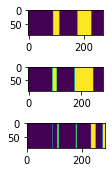

(90, 272)
(94, 284)
(90, 284)


In [ ]:
outfile = '/content/drive/MyDrive/Thin_layers_data/new_data/layers5_DNN_' + str(running_number) + '_filters.npz'
npzfile = np.load(outfile)
d = dict(npzfile)
plt.figure()
plt.subplot(3,1,1)
plt.imshow(d['original200'])
plt.subplot(3,1,2)
plt.imshow(d['prediction200'])
plt.subplot(3,1,3)
plt.imshow(d['subtraction200'])
plt.show()
print(d['original200'].shape)
print(d['prediction200'].shape)
print(d['subtraction200'].shape)

In [ ]:
# Saving images as PDF

plt.rcParams["figure.figsize"] = [15, 7.50]
plt.rcParams["figure.autolayout"] = True

for i in range(300):
  index = i
  n_original = y_test[index][0,0]
  d_original = y_test[index,:,1] * (10**-7)

  y_pred = model.predict([x_test[:,:,0], x_test[:,:,1]])
  n_prediction_vector = np.float32(y_pred[1] < 0.5)[:,0]
  d_prediction_vector = y_pred[0]* (10**-7)

  n_prediction = n_prediction_vector[index]
  d_prediction = d_prediction_vector[index]

  NDlist_original = create_NDlist(n_original, d_original)
  NDlist_prediction = create_NDlist(n_prediction, d_prediction)

  plt.figure()
  image_original = plot_structure(NDlist_original)
  image_prediction = plot_structure(NDlist_prediction)
  correlation_structure = int(calculate_correlation_structure(NDlist_original, NDlist_prediction) * 100)
  plt.subplot(3,2,1)
  plt.imshow(image_original)
  plt.title('original- one pixel = 100nm | structure correlation: {}%'.format(correlation_structure))
  plt.subplot(3,2,3)
  plt.imshow(image_prediction)
  plt.title('prediction- one pixel = 100nm | structure correlation: {}%'.format(correlation_structure))
  plt.subplot(3,2,2)
  x_t_original, y_t_original = non_zero(t_vec, x_test[index, :,0])
  x_r_original, y_r_original = non_zero(t_vec, x_test[index, :,1])
  plt.plot(x_t_original, y_t_original)
  plt.plot(x_r_original, y_r_original)
  plt.legend(['T' , 'R'])
  plt.title("original")
  plt.subplot(3,2,4)
  y_t_prediction0, y_r_prediction0 = generate_vector(add_air(NDlist_prediction))
  x_t_prediction, y_t_prediction = non_zero(t_vec, y_t_prediction0)
  x_r_prediction, y_r_prediction = non_zero(t_vec, y_r_prediction0)
  plt.plot(x_t_prediction, y_t_prediction)
  plt.plot(x_r_prediction, y_r_prediction)
  plt.legend(['T' , 'R'])
  plt.title("prediction")
  plt.subplot(3,2,5)
  plt.plot(x_t_original, y_t_original)
  plt.plot(x_t_prediction, y_t_prediction)
  plt.legend(['orig' , 'pred'])
  correlation_t = int(100 * np.abs(np.corrcoef(x_test[index, :,0], y_t_prediction0)[0,1]))
  plt.title('T - correlation: {}%'.format(correlation_t))
  plt.subplot(3,2,6)
  plt.plot(x_r_original, y_r_original)
  plt.plot(x_r_prediction, y_r_prediction)
  plt.legend(['orig' , 'pred'])
  correlation_r = int(100 * np.abs(np.corrcoef(x_test[index, :,1], y_r_prediction0)[0,1]))
  plt.title('R - correlation: {}%'.format(correlation_r))


def save_multi_image(filename):
   pp = PdfPages(filename)
   fig_nums = plt.get_fignums()
   figs = [plt.figure(n) for n in fig_nums]
   for fig in figs:
      fig.savefig(pp, format='pdf')
   pp.close()

filename = '/content/drive/MyDrive/Thin_layers_data/new_data/layers5_DNN_' + str(running_number) + '.pdf'
save_multi_image(filename)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# NOT FOR RUNNING

from sklearn.model_selection import train_test_split

random_state = 9990
test_size = 0.1

x_samples = np.dstack((vec_T, vec_R))
y_samples = vec_structure[:,:,:2].astype(np.float32)

x_train, x_test, y_train, y_test = train_test_split(x_samples, y_samples, 
                                                    test_size=test_size,
                                                    random_state = random_state)

x_test, x_dev, y_test, y_dev = train_test_split(x_test, y_test, 
                                                    test_size=0.5,
                                                random_state=0)

outfile = "/content/drive/MyDrive/Thin_layers_data/layers5_DNN_y_test"
savez_dict = {}
np.savez(outfile, layers5_DNN_y_test = y_test)

In [ ]:
# NOT FOR RUNNING

outfile = '/content/drive/MyDrive/Thin_layers_data/layers5_DNN_y_test.npz'
npzfile = np.load(outfile)
d = dict(npzfile)
print(d['layers5_DNN_y_test'][1])

[[ 1.        93.130005 ]
 [ 3.4777238 16.33     ]
 [ 1.4440236 41.100002 ]
 [ 3.4777238 70.42     ]
 [ 1.4440236 13.09     ]]
